## Imports

In [1]:
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot as plt
from scipy.signal    import find_peaks
from scipy.integrate import simps, trapz
from scipy.optimize  import curve_fit

# Lendo arquivo das waveforms

#### O arquivo original já foi parcialmente modificado em relação a linhas e colunas

In [2]:
%%time
'''Lendo arquivo das waveforms'''

waveform = pd.read_csv(
    '5555_eventos-edit.csv', 
    index_col = 0
                      ) # importa como waveform vs sample
waveform

Wall time: 2.68 s


,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554,time
0,56.0,56.0,56.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,54.0,53.0,53.0,51.0,51.0,51.0,51.0,51.0,51.0,0
1,55.0,55.0,55.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,52.0,52.0,52.0,52.0,51.0,51.0,51.0,51.0,51.0,1
2,53.0,53.0,53.0,51.0,53.0,53.0,55.0,55.0,55.0,55.0,...,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0,2
3,53.0,53.0,53.0,52.0,53.0,53.0,54.0,54.0,54.0,54.0,...,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0,3
4,54.0,54.0,54.0,53.0,55.0,55.0,55.0,55.0,55.0,55.0,...,51.0,53.0,53.0,52.0,54.0,54.0,54.0,54.0,54.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,53.0,53.0,53.0,54.0,55.0,55.0,22.0,22.0,22.0,22.0,...,54.0,50.0,50.0,50.0,52.0,52.0,52.0,52.0,52.0,2495
2496,55.0,55.0,55.0,54.0,56.0,56.0,14.0,14.0,14.0,14.0,...,50.0,51.0,51.0,53.0,51.0,51.0,51.0,51.0,51.0,2496
2497,52.0,52.0,52.0,53.0,53.0,53.0,37.0,37.0,37.0,37.0,...,53.0,51.0,51.0,53.0,52.0,52.0,52.0,52.0,52.0,2497
2498,52.0,52.0,52.0,53.0,54.0,54.0,51.0,51.0,51.0,51.0,...,52.0,53.0,53.0,52.0,52.0,52.0,52.0,52.0,52.0,2498


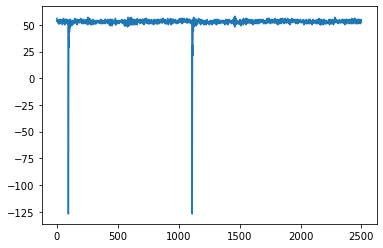

In [3]:
plt.plot( waveform.time, waveform.event_0 )

# Construindo os métodos para a análise de dados

#### 1. Peak_finder 

Auxilia a encontrar todos os picos de uma waveform. No caso, encontra dois picos.


In [4]:
def peak_finder(series, height): # peak_finder se aplica em data frames com valores do eixo y    
    '''
    Essa função retorna os valores no eixo x
    '''
    
    # get the actual peaks
    peaks, _ = find_peaks( (-1)*series, height = height ) # height é um parâmetro decidido
    
    return(peaks)

In [5]:
'''
Essa função utiliza a peak_finder e já retorna os dados como uma Series com os valores em x e y de cada pico
'''

def peak_finder_xy(series, height): 
    __ = peak_finder(series, height = height)
    
    return(series.iloc[__])

#### 2. delta_signal

Encontra as diferenças entre elementos lado-a-lado. Serve para avaliar quando estamos começando ou terminando um pulso.

In [6]:
def delta_x(s): # insira uma series na entrada; o valor retornado está em coordenadas do eixo x
    VA_derivada_baseLine = 5  #   flutuação/amplitude máxima da base-line;
                              #   valor arbirtrário para saber se o número em questão está fora da 
                              # base-line; não é exatamente a derivada
    _ = []
    for i in range( len(s) - 1 ): # i = index da series
        if abs(s[i] - s[i+1]) > VA_derivada_baseLine:
            _.append(i) 
        
    return (_) # o valor retornado está em coordenadas do eixo x

#### 3. contorno_pulso

Encontra os valores dos dois pulsos em cada uma das waveforms. Utiliza as duas funções anteriores. 
Funciona da seguinte maneira: encontra os picos e delimita os entornos. Daí, guarda os pontos interiores do pulso e os devolve.

In [7]:
def contorno_pulso(series, VA_1, VA_2): # recebe uma Series do pandas para começar
    
    
    '''
    Define um recorte de onde se deve buscar um pulso e os seus delimitadores
    VA_1 e VA_2 são variáveis arbitrárias para definir a largura do pulso 
    '''
    

    peak = peak_finder(series, height) # encontrar os picos da waveform
    
    s1 = series[ (peak[0] - VA_1):(peak[0] + VA_2) ] # recortar envolta dos picos
    s2 = series[ (peak[1] - VA_1):(peak[1] + VA_2) ]
    
    df1 = pd.DataFrame( dict(s1 = s1) ).reset_index() # cria um Data Frame com os valores do recorte
    df1.columns = ['time', 's1']                      # renomeia a coluna do data frame
    df2 = pd.DataFrame( dict(s1 = s2) ).reset_index()
    df2.columns = ['time', 's2']
    
    
    

    '''
    Calcular a "derivada" em cada ponto no entorno, para saber os limitantes do pulso
    Ao terminar, retornar o data frame que contem os valores limitantes do contorno do pulso
    '''  

    indexLim_1 = delta_x( df1['s1'] ) # índices limitantes
    indexLim_2 = delta_x( df2['s2'] )
    
    # redefine os valores para apenas os limitantes do data frame
    df1 = df1.iloc[    [  indexLim_1[0], indexLim_1[-1]  ]    ] 
    df2 = df2.iloc[    [  indexLim_2[0], indexLim_2[-1]  ]    ] 
    
    # print(df2) # series marcada pelas colunas 
    
    
    # da Series original, temos agora o contorno do pulso
    s1 = series[ df1['time'].iloc[0] : df1['time'].iloc[1]+1 ] # soma 1 para incluir o último termo
    s2 = series[ df2['time'].iloc[0] : df2['time'].iloc[1]+1 ] 
    
    # print(s2)
    
    pulsos = s1, s2
    
    
    
    
    
    
    return(pulsos) # retorna os dois contornos, um de cada pulso

#### 4. integral_simples

Calcula a integral do contorno do pulso da waveform

In [8]:
def integral_simples(dados_em_y, dx):
    
    _ = dados_em_y
    I = 0
    
    for i in range(len(_)):
        y = _.iloc[i]
        I += y * dx
    
    return(I)

#### 5. baseLine_sample

Retorna uma amostra da waveform para determinar o valor estatístico dela

In [9]:
'''
Definimos essa função que retorna uma sample da base line da waveform
'''

def baseLine_sample(series, height): # recebe uma series do pandas
    
    _ = peak_finder(series, height = height)
    
    '''Pega todos os elementos até o início do primeiro pulso; intervalo exclusivo à direita'''
    
    if len(_) != 0: # pode acontecer de que o peak_finder não 
        
        x_inicio_pulso_0 = _[0] - VA_1 # definido arbitrariamente
        # print(x_inicio_pulso_0)
    
        sample  = evento.iloc[:x_inicio_pulso_0]
        
    else:
        #print(f'problema em {_s.name}')
        sample = None

    return( sample ) # este elemento é uma Series

# 3. Análise de dados

## 3.1. Copia o data frame e seleciona a janela de busca

Cria uma cópia das waveforms para poder transladar o base line sem modificar os dados originais;

Define a janela onde procuraremos pelos valores do contorno do pulso

In [10]:
df = waveform.copy(deep = True)

VA_1 = 20 # VA_1 e VA_2 são variáveis arbitrárias para definir o majorante da largura dos pulsos
VA_2 = 70

convert_to_microsec = 1/250

df.head()

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554,time
0,56.0,56.0,56.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,54.0,53.0,53.0,51.0,51.0,51.0,51.0,51.0,51.0,0
1,55.0,55.0,55.0,53.0,55.0,55.0,54.0,54.0,54.0,54.0,...,52.0,52.0,52.0,52.0,51.0,51.0,51.0,51.0,51.0,1
2,53.0,53.0,53.0,51.0,53.0,53.0,55.0,55.0,55.0,55.0,...,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0,2
3,53.0,53.0,53.0,52.0,53.0,53.0,54.0,54.0,54.0,54.0,...,53.0,53.0,53.0,50.0,55.0,55.0,55.0,55.0,55.0,3
4,54.0,54.0,54.0,53.0,55.0,55.0,55.0,55.0,55.0,55.0,...,51.0,53.0,53.0,52.0,54.0,54.0,54.0,54.0,54.0,4


## 3.2. Translação da base-line

É interessante transladar os pontos e fixar a base line no 0. Podemos fazer isso somando ~= -50 em cada um dos valores de toda a coleção de waveforms. Isso servirá para evitar problemas de 'height' no peak_finder()

Análise estatística do base-line:
No caso, tomaremos todos os dados antes do primeiro pulso de cada waveform e consideraremos o base-line como o mesmo para todos os waveforms

#### Método:

Para encontrar a base line, selecionaremos a parte mais à esquerda, antes do pulso. 
Esse pedaço é definido como fora de um valor arbitrário em torno do primeiro pico da waveform, que acaba não sofrendo com a questão da base line. Definimos desse jeito porque a função para calcular o contorno do pulso, além de demorar para ser computada, sofre com as questões do peak_finder acabar encontrando apenas um elemento


In [11]:
%%time

height = 50 # esse parâmetro aqui é somente para efeito de encontrar os elementos da  base line a priori

baseLines = [] # será uma lista de series
for i in range( df.shape[1] - 1 ):
    evento = df[ df.columns[i] ]
    baseLines.append(baseLine_sample(evento, height))
baseLines = pd.concat(baseLines)

Wall time: 1.65 s


In [12]:
baseLines

0       56.0
1       55.0
2       53.0
3       53.0
4       54.0
        ... 
1711    52.0
1712    52.0
1713    53.0
1714    52.0
1715    51.0
Length: 641964, dtype: float64

In [13]:
baseLines.value_counts()

 52.0    191655
 53.0    188183
 51.0    102052
 54.0     91012
 50.0     29971
          ...  
-21.0         5
-40.0         4
 61.0         4
-19.0         4
-42.0         2
Length: 110, dtype: int64

In [14]:
# baseLines.mean() , baseLines.std()

#### Relocação do base-line
Colocando o valor médio do base line como o parâmetro height do peak-finder, surpreendentemente temos um resultado que não incorre em erros na hora de achar os dois picos de cada waveform. No caso, ele acaba por achar dois picos (não mais nem menos) de maneira mais fácil e exata

In [15]:
'''
Alterando os valores e recolocando na base line ~= 0
'''

df.iloc[ :  , : waveform.shape[1] - 1 ] -= baseLines.mean() # soma ~= -50 em todo o df, exceto pela última coluna 'time'
df

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,...,event_5546,event_5547,event_5548,event_5549,event_5550,event_5551,event_5552,event_5553,event_5554,time
0,3.72321,3.72321,3.72321,0.72321,2.72321,2.72321,1.72321,1.72321,1.72321,1.72321,...,1.72321,0.72321,0.72321,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679,0
1,2.72321,2.72321,2.72321,0.72321,2.72321,2.72321,1.72321,1.72321,1.72321,1.72321,...,-0.27679,-0.27679,-0.27679,-0.27679,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679,1
2,0.72321,0.72321,0.72321,-1.27679,0.72321,0.72321,2.72321,2.72321,2.72321,2.72321,...,0.72321,0.72321,0.72321,-2.27679,2.72321,2.72321,2.72321,2.72321,2.72321,2
3,0.72321,0.72321,0.72321,-0.27679,0.72321,0.72321,1.72321,1.72321,1.72321,1.72321,...,0.72321,0.72321,0.72321,-2.27679,2.72321,2.72321,2.72321,2.72321,2.72321,3
4,1.72321,1.72321,1.72321,0.72321,2.72321,2.72321,2.72321,2.72321,2.72321,2.72321,...,-1.27679,0.72321,0.72321,-0.27679,1.72321,1.72321,1.72321,1.72321,1.72321,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.72321,0.72321,0.72321,1.72321,2.72321,2.72321,-30.27679,-30.27679,-30.27679,-30.27679,...,1.72321,-2.27679,-2.27679,-2.27679,-0.27679,-0.27679,-0.27679,-0.27679,-0.27679,2495
2496,2.72321,2.72321,2.72321,1.72321,3.72321,3.72321,-38.27679,-38.27679,-38.27679,-38.27679,...,-2.27679,-1.27679,-1.27679,0.72321,-1.27679,-1.27679,-1.27679,-1.27679,-1.27679,2496
2497,-0.27679,-0.27679,-0.27679,0.72321,0.72321,0.72321,-15.27679,-15.27679,-15.27679,-15.27679,...,0.72321,-1.27679,-1.27679,0.72321,-0.27679,-0.27679,-0.27679,-0.27679,-0.27679,2497
2498,-0.27679,-0.27679,-0.27679,0.72321,1.72321,1.72321,-1.27679,-1.27679,-1.27679,-1.27679,...,-0.27679,0.72321,0.72321,-0.27679,-0.27679,-0.27679,-0.27679,-0.27679,-0.27679,2498


# 4. Preparação dos dados para o plot
Selecionamos os picos, no eixo y, em cada pulso e plotamos um histograma

## 4.1. Loop para construção e check do peak_finder
Esse loop cria e checa se existem erros na obtenção dos picos através da função peak-finder, quando peaks != 2

In [16]:
%%time
peaks_em_x = []
counter = 0
for i in range(df.shape[1] - 1):
    evento = df[ df.columns[i] ]
    _ = peak_finder(evento, height = baseLines.mean())
    if len(_) != 2:
        print(f'problema no {evento.name} com tamanho = {len(_)} e picos em {_}')
        counter += 1
    peaks_em_x.append(_)

print(f'\nloop finalizado com {counter} erros')


loop finalizado com 0 erros
Wall time: 5.89 s


In [17]:
# peaks_em_x[0]

## 4.2. Histograma com os valores de diferença de tempo

In [18]:
_ = pd.DataFrame(   peaks_em_x,  columns = ['peak_0', 'peak_1']   )
delta_x = (   _['peak_1']  -  _['peak_0']   )
delta_x.name = 'delta_x'

Desenha o histograma

Text(0.5, 0, 'Diferença de tempo (micro seg)')

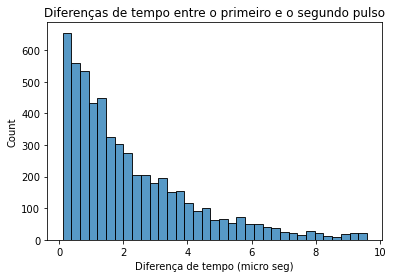

In [19]:
sns.histplot(delta_x*convert_to_microsec)
plt.title('Diferenças de tempo entre o primeiro e o segundo pulso')
plt.xlabel('Diferença de tempo (micro seg)')

## 4.3. Ajuste da curva exponencial

In [20]:
'''
Definimos a função de ajuste para a exponencial
'''

def fit_function(t, A, tau, C): # função de ajuste exponencial
    return(  A * np.e**(-t/tau) + C  )

(b) Coletamos os dados e fazemos plots preliminares, para ir acompanhando os resultados


Obs.: a variável number_of_bins é o jeito padrão de quantificar quantos bins se tem num histograma

fonte: https://stackoverflow.com/questions/60512271/how-can-i-extract-the-bins-from-seaborns-kde-distplot-object

Text(0.5, 0, 'Diferença de tempo (ADC)')

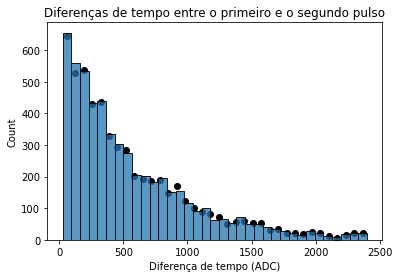

In [21]:
'''
Coletando os dados do histograma para o plot
'''
number_of_bins     = min(  len( np.histogram_bin_edges(delta_x, bins="fd") ), 50  )
data_entries, bins = np.histogram(delta_x , bins = number_of_bins)
bins_centers       = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

'''
Plot para acompanhar o procedimento do desenho do gráfico
'''
sns.histplot(delta_x)
plt.scatter(bins_centers, data_entries, color = 'black')
plt.title('Diferenças de tempo entre o primeiro e o segundo pulso')
plt.xlabel('Diferença de tempo (ADC)')

(c) Fazemos a regressão pela curve_fit do Scipy

obs.: É importante dar um valor inicial para os parâmetros, como um chute inicial. Nesse caso, eu apenas chutei os valores mesmo algumas vezes

In [22]:
p0 = np.array([ 0.5, 10, 1 ]) # initial guess for the parameters
opt_coeff, cov_coeff = curve_fit(  fit_function , xdata = bins_centers , ydata = data_entries, p0 = p0  )

(d) Plot com histograma e regressão da curva

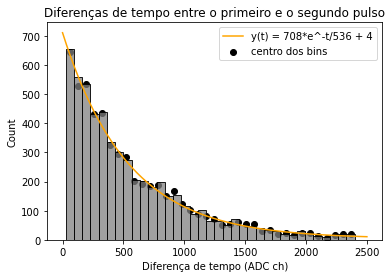

In [23]:
# plot do histograma
sns.histplot(delta_x, color='gray')

# plot dos centros dos bins
plt.scatter(bins_centers, data_entries, color = 'black', label = 'centro dos bins')

# plot da curve_fit
x = np.linspace(0,2500, 10000)
plt.plot( 
    x, fit_function(x, *opt_coeff), 
    color = 'orange', label = f'y(t) = {round(opt_coeff[0])}*e^-t/{round(opt_coeff[1])} + {round(opt_coeff[2])}' )

# detalhes
plt.title('Diferenças de tempo entre o primeiro e o segundo pulso')
plt.xlabel('Diferença de tempo (ADC ch)')
plt.legend()

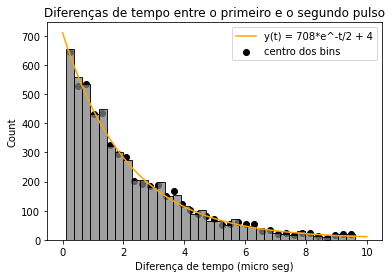

In [24]:
# converter os resultados para as unidades corretas
coeff = np.array([ opt_coeff[0], opt_coeff[1]*convert_to_microsec, opt_coeff[2] ])

# plot do histograma
sns.histplot(delta_x*convert_to_microsec, color='gray')

# plot dos centros dos bins
plt.scatter(bins_centers*convert_to_microsec, data_entries, color = 'black', label = 'centro dos bins')

# plot da curve_fit
x = np.linspace(0,10, 10000)
plt.plot( 
    x, fit_function(x, coeff[0], coeff[1], coeff[2]), 
    color = 'orange', label = f'y(t) = {round(coeff[0])}*e^-t/{round(coeff[1])} + {round(coeff[2])}' )

# detalhes
plt.title('Diferenças de tempo entre o primeiro e o segundo pulso')
plt.xlabel('Diferença de tempo (micro seg)')
plt.legend()

In [25]:
coeff_results = pd.DataFrame(coeff)
coeff_results.rename( columns = {0:'valor'}, index ={ 0:'A', 1:'tau', 2:'C' } , inplace = True )
coeff_results

,valor
A,707.655718
tau,2.143807
C,3.960233


## 4.2. Filtrando os dados de acordo com o valor do tempo de vida do muon

In [26]:
delta_x = delta_x.where(delta_x <= 5*250).dropna()

Redefinimos o df original para agora ser esse filtrado

In [27]:
df = df.iloc[: , delta_x.index]

## 4.2. Observação

A célula abaixo mostra uma Series que foi recortada do df original. Ela contem exatamente os valores em x e y do pico do evento selecionado.

Todavia, eu não consegui pensar num método tão simples para retirar somente a primeira linha, porque isto é uma Series (só tem a coluna da direita) e não um Data Frame. Salvar o valor da coordenada x, embora não tão necessário para nossos propósitos agora, pode ser útil no futuro.

Eu pensei em duas soluções, que na verdade são três. 

1) Transformar num data frame cada uma das series e guardar os valores

2) Resgatar o índice (a coordenada x) manualmente

3) Fazer alguma dessas duas coisas em alguma parte anterior do código

Acabou que eu pensei melhor e decidi por concatenar todos esses valores em apenas uma única Series, preparando os elementos para o plot do espectro de amplitude. Depois disso, separamos cada um em seu respectivo pulso.

In [28]:
df.iloc[: , 0][peaks_em_x[0]]

94     -179.27679
1111   -179.27679
Name: event_0, dtype: float64

In [29]:
%%time
peaks_em_xy = pd.Series([])
for i in range( df.shape[1] - 1 ):
    evento = df[ df.columns[i] ]
    _ = peak_finder_xy(evento, height = baseLines.mean())
    peaks_em_xy = pd.concat([  peaks_em_xy, _  ])
if len(peaks_em_xy) != 2*(df.shape[1] - 1): # se ele reconhe algo diferente de dois picos por waveform:
    print(f'existe um erro nos picos, pois aparece(m) {len(peaks_em_xy) - 2*(df.shape[1] - 1)} pico(s) a mais')
else:
    print('não foram detectados problemas na quantidade de picos')

não foram detectados problemas na quantidade de picos
Wall time: 7.24 s


## 4.3. Esses são os picos em cooordenadas de xy

In [30]:
peaks_em_xy = pd.DataFrame(peaks_em_xy).reset_index()
peaks_em_xy.columns = ['x', 'y']
peaks_em_xy

,x,y
0,94,-179.27679
1,1111,-179.27679
2,94,-179.27679
3,1111,-179.27679
4,94,-179.27679
...,...,...
10003,754,-179.27679
10004,94,-160.27679
10005,527,-146.27679
10006,94,-160.27679


## 4.4. Separar os picos em relação ao primeiro e segundo pulso

In [31]:
peaks_0,   peaks_1   =   peaks_em_xy.query('index % 2 == 0'),   peaks_em_xy.query('index % 2 != 0')
peaks_0.head(10)

,x,y
0,94,-179.27679
2,94,-179.27679
4,94,-179.27679
6,94,-179.27679
8,94,-179.27679
10,94,-179.27679
12,94,-160.27679
14,94,-160.27679
16,94,-179.27679
18,94,-179.27679


# 5. Plot espectro de amplitude

## 5.1. Plot do espectro de amplitude do primeiro pulso 

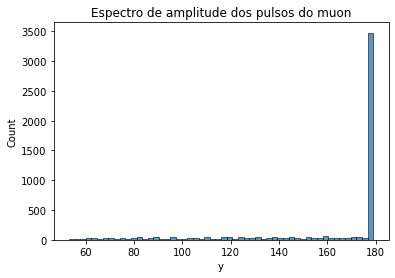

In [32]:
sns_plot = sns.histplot( -1*peaks_0.y.round() )
#plt.xlim(0, 175)
plt.title('Espectro de amplitude dos pulsos do muon')
plt.savefig("espectro_amplitude-pulso_0.png", dpi = 150, transparent = True)

## 5.2. Plot do espectro de amplitude do primeiro pulso, removendo a saturação dos picos (com zoom)

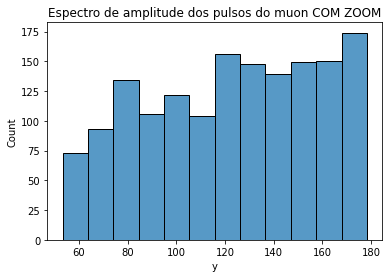

In [33]:
sns_plot = sns.histplot( -1*peaks_0.query('y > y.min()').y )
plt.title('Espectro de amplitude dos pulsos do muon COM ZOOM')
plt.savefig("espectro_amplitude-pulso_0_ZOOM.png", dpi = 150, transparent = True)

In [34]:
peaks_0.y.round().value_counts()

-179.0    3456
-119.0      29
-136.0      26
-151.0      23
-168.0      23
          ... 
-71.0        4
-108.0       3
-103.0       3
-54.0        1
-53.0        1
Name: y, Length: 127, dtype: int64

In [35]:
peaks_0.query('y > y.min()').y

12      -160.27679
14      -160.27679
26      -139.27679
42      -142.27679
48      -104.27679
           ...    
9964    -136.27679
9996    -124.27679
9998    -124.27679
10004   -160.27679
10006   -160.27679
Name: y, Length: 1548, dtype: float64

## 5.3. Plot do espectro de amplitude do segundo pulso 

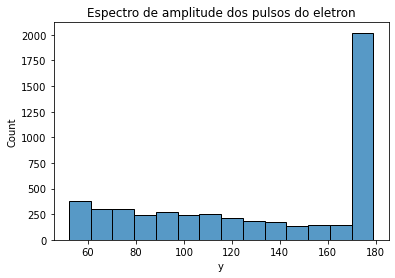

In [36]:
sns.histplot( -1*peaks_1.y.round() )
plt.title('Espectro de amplitude dos pulsos do eletron')
plt.savefig("espectro_amplitude-pulso_1.png", dpi = 150, transparent = True)

## 5.4. Plot do espectro de amplitude do primeiro pulso, removendo a saturação dos picos (com zoom)

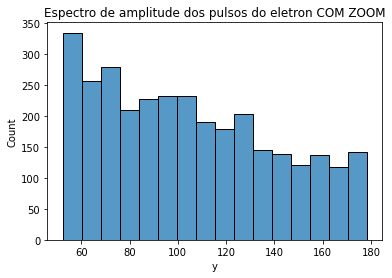

In [37]:
sns.histplot( -1*peaks_1.query('y > y.min()').y )
plt.title('Espectro de amplitude dos pulsos do eletron COM ZOOM')
plt.savefig("espectro_amplitude-pulso_1_ZOOM.png", dpi = 150, transparent = True)

In [38]:
peaks_1.y.round().value_counts()

-179.0    1865
-55.0       55
-58.0       53
-59.0       49
-73.0       44
          ... 
-158.0      10
-176.0      10
-137.0      10
-151.0       9
-155.0       8
Name: y, Length: 128, dtype: int64

# 6. Plot dos espectro de carga

## 6.1. Procuramos agora os contornos dos pulsos

In [39]:
%%time

'''
Esse loop serve para olhar, em cada waveform do Data Frame original, o contorno ao redor de cada pulso, selecionado através do pico e das larguras arbitradas 
'''

contorno_0 = []
contorno_1 = []

for i in range( df.shape[1] - 1 ): 
    
    evento = df[ df.columns[i] ]
    s0 = evento.where( (evento.index >= peaks_0.x.iloc[i] - VA_1) & (evento.index <= peaks_0.x.iloc[i] + VA_2) ).dropna()
    s1 = evento.where( (evento.index >= peaks_1.x.iloc[i] - VA_1) & (evento.index <= peaks_1.x.iloc[i] + VA_2) ).dropna()
    
    contorno_0.append(s0)
    contorno_1.append(s1)

Wall time: 7.96 s


### Checando os tamanhos dos contornos e a quantidade de elementos em cada sample

In [40]:
%%time
'''
Loop de checagem dos contornos
'''

if ( len(contorno_0) and len(contorno_1) ) != df.shape[1] - 1:
    _  = abs( len(contorno_0) - len(contorno_1) )
    __ = 'primeiro' if len(contorno_0) > len(contorno_1) else 'segundo'
    print(f'Os contornos não batem no tamanho. Existe(m) {_} a mais no {__}')

for elemento in (contorno_0 or contorno_1):
    if len(elemento) != VA_1 + VA_2 + 1:
        print(f'Erro no {elemento.name}')

Wall time: 6 ms


## 6.2. Integração do pulso 

Integramos o pulso para obter a carga gerada com ele. Utilizamos a integração pelo método de Simpson.

In [41]:
"""

%%time
'''
Calculando as integrais por Simpson
'''

integrais_0 = np.array([])
integrais_1 = np.array([])

for i in range(df.shape[1] - 1):
    integrais_0 = np.append(  integrais_0, -1*simps(contorno_0[i], dx = 1)  )
    integrais_1 = np.append(  integrais_1, -1*simps(contorno_1[i], dx = 1)  )
    
integrais_0 = pd.Series(integrais_0, name ='pulso_0')
integrais_1 = pd.Series(integrais_1, name ='pulso_1')

"""

print()

Integral por método alternativo

Se quiser comparar com uma integral mais simples, aqui está. O resultado dá praticamente o mesmo do que o método de Simpson (sendo que este é mais confiável)

In [42]:
"""

%%time

'''
Regra do trapézio
'''

integrais_trapezio_0 = np.array([])

for i in range(df.shape[1] - 1): #df.shape[1] - 1
    integrais_trapezio_0 = np.append(  integrais_trapezio_0, -1*trapz(contorno_0[i], dx = 1)  )
    
integrais_trapezio_0 = pd.Series(integrais_trapezio_0, name = 'pulso_0')
integrais_trapezio_0.value_counts().sort_index()

"""

print()

In [43]:
%%time

'''
Regra mais simples para o pulso_0
'''

integrais_simples_0 = np.array([])

for i in range(df.shape[1] - 1): #df.shape[1] - 1
    integrais_simples_0 = np.append(  integrais_simples_0, -1*integral_simples(contorno_0[i], dx = 1)  )
    
integrais_simples_0 = pd.Series(integrais_simples_0, name = 'pulso_0')

Wall time: 3.39 s


In [44]:
integrais_simples_0.value_counts().sort_index()

105.187859     1
113.187859     3
124.187859     1
132.187859     2
135.187859     3
              ..
1669.187859    1
1676.187859    1
1703.187859    1
1737.187859    1
1779.187859    1
Name: pulso_0, Length: 1399, dtype: int64

In [45]:
# abs(integrais_0 - integrais_simples_0).value_counts().sort_index()

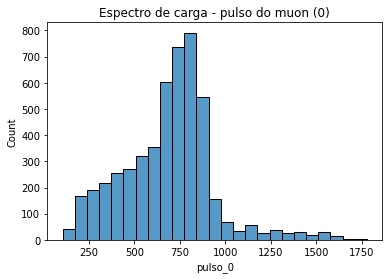

In [46]:
sns.histplot(data = integrais_simples_0, bins = 25).set_title("Espectro de carga - pulso do muon (0)")
plt.savefig("espectro_carga-pulso_0.png", dpi = 150, transparent = True)

In [47]:
#sns.histplot(data = integrais_trapezio_0).set_title("Integrais por trapézio")

In [48]:
#sns.histplot(data = integrais_0).set_title("Integrais por Simpson")
#plt.savefig("espectro_integral_pulso_0.png", dpi = 150, transparent = True)

In [49]:
%%time

'''
Regra mais simples para o pulso_1
'''

integrais_simples_1 = np.array([])

for i in range(df.shape[1] - 1): #df.shape[1] - 1
    integrais_simples_1 = np.append(  integrais_simples_1, -1*integral_simples(contorno_1[i], dx = 1)  )
    
integrais_simples_1 = pd.Series(integrais_simples_1, name = 'pulso_1')

Wall time: 3.14 s


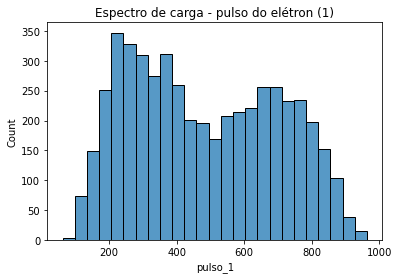

In [50]:
sns.histplot(data = integrais_simples_1, bins = 25).set_title("Espectro de carga - pulso do elétron (1)")
plt.savefig("espectro_carga-pulso_1.png", dpi = 150, transparent = True)

In [51]:
integrais_simples_0.value_counts().sort_index()

105.187859     1
113.187859     3
124.187859     1
132.187859     2
135.187859     3
              ..
1669.187859    1
1676.187859    1
1703.187859    1
1737.187859    1
1779.187859    1
Name: pulso_0, Length: 1399, dtype: int64

In [52]:
integrais_simples_1.value_counts().sort_index()

62.187859     1
80.187859     2
85.187859     1
104.187859    1
107.187859    1
             ..
936.187859    3
941.187859    1
944.187859    2
960.187859    1
963.187859    4
Name: pulso_1, Length: 1225, dtype: int64

In [53]:
#peaks_em_x[0]

In [54]:
# aux = []
#counter = 0
#for i in range( len(peaks_em_x) ):
#    _ = peaks_em_x[i][1] - peaks_em_x[i][0]
#    if _ <= 5*250:
#        aux.append(_)
#    else:
#        counter += 1
#        
#print(f'descartado(s) {counter} elemento(s)')

In [55]:
#aux